In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib
from sklearn.metrics import roc_curve, auc
import seaborn as sns

import lightgbm as lgb
import utils

#supression warnings
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Load data

In [2]:
data_path = './data/jlr_all_user_processed.xlsx'
df = pd.read_excel(data_path)
df.head(2)

,user_id,follow_count,fans_count,gender,birthday,location,level,registration_time,properties,mileage,...,car_friend_zone,label,car_like,excellent_post_count,all_post_count,regis_year,regis_month,regis_day,date,date_delta
0,oden123,0,0,2,NaT,1,1,2018-03-26,1,4430,...,NaN,True,1,0,0,2018,3,3,2018-03-26,4522
1,生活1934626,2,4,2,NaT,2,1,2012-05-07,1,4270,...,"[{'名称': '汽车之家甘肃论坛车友会', '人数': 672, '创建时间': '201...",True,2,0,0,2012,5,5,2012-05-07,2373


In [3]:
# df.keys(), df.dtypes

### Data choosing  
we choose some features to build the machine learning model

In [35]:
x = df.drop(columns=[
                      'user_id',
#                      'follow_count',
#                      'fans_count', 
#                      'gender', 
                     'birthday',
#                      'location',
#                      'level',
                     'registration_time',
#                      'properties',
#                      'mileage',
                      'post',
                      'cars',
                      'koubei_post',
                      'gas_mileage',
                      'car_friend_zone',
                      'label',
#                      'car_like', 
                     'excellent_post_count',
                     'all_post_count',
                      'regis_year',
                      'regis_month',
                      'regis_day', 
                      'date',
#                      'date_delta'
                     ])
x.head(2)

,follow_count,fans_count,gender,location,level,properties,mileage,car_like,date_delta
0,0,0,2,1,1,1,4430,1,4522
1,2,4,2,2,1,1,4270,2,2373


In [36]:
y = df['label'].astype('uint8')
utils.exploreCat(df, 'label')

In [37]:
# dataset size
_x, _y = np.array(x).astype('int'), np.array(y).astype('int')
_x.shape, _y.shape

((5555, 9), (5555,))

In [38]:
sum(_y==0),sum(_y==1)

(4830, 725)

### Split dataset into train/validation/test set
train:validation:test = 8:1:1

In [39]:
# x_train, x_test, y_train, y_test = train_test_split(_x, _y, test_size=0.2,  random_state = 40)
# x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5,  random_state = 40)

# print(x_train.shape, x_val.shape, x_test.shape)

In [40]:
# # positive/negative propotion in dataset
# print("In train set, positive : negative = {}:{}=1:{} ".format(sum(y_train==1),sum(y_train==0), sum(y_train==0)/sum(y_train==1)))
# print("In validation set, positive : negative = {}:{}=1:{}".format(sum(y_val==1),sum(y_val==0), sum(y_val==0)/sum(y_val==1)))
# print("In test set, positive : negative = {}:{}=1:{}".format(sum(y_test==1),sum(y_test==0),sum(y_test==0)/sum(y_test==1)))

### Create KFolder dataset

In [41]:
from scipy import interp
from itertools import cycle

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report
import time
import random
random.seed(42)

In [42]:
def kfolder_plot(train, ytrain, model):
    """
    Args:
    - train: dataframe
    """
    kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    scores = []
    mean_tpr = 0.0
    mean_fpr = np.linspace(0,1,100)
    exe_time = []
    bst_models = {}
    y_preds = {}
    
    colors = cycle(['cyan', 'orange', 'seagreen', 'yellow', 'blue'])
    lw = 2
    
    i = 0
    for(train_idx, test_idx), color in zip(kf.split(train, ytrain), colors):
#         print(train_idx, test_idx)
        x_train, x_test = train.iloc[train_idx], train.iloc[test_idx]
        y_train, y_test = ytrain.iloc[train_idx], ytrain.iloc[test_idx]
#         print(test_idx)
        start = time.time()
        
        bst_model, predictions = model(x_train, x_test, y_train)
        y_preds[i] = predictions
        bst_models[i] = bst_model
        
        end = time.time()
        exe_time.append(round(end-start, 3))
        
        scores.append(roc_auc_score(y_test.astype(float), predictions))
        fpr, tpr, thresholds = roc_curve(y_test, predictions>=0.5)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
#         print("roc_auc: ", roc_auc)
        plt.plot(fpr, tpr, lw=lw, color=color, label='ROC fold %d (area=%0.2f)'%(i, roc_auc))
        i += 1
#         print(classification_report(y_test, predictions>=0.5))

    plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k', label='ROC baseline')
    mean_tpr /= kf.get_n_splits(train, ytrain)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='r', linestyle='--', label='Mean ROC(are a = %0.2f)'%mean_auc, lw=lw)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC KFolder')
    plt.legend(loc='lower right')
    plt.show()
    
    print('mean scores: ', np.mean(scores))
    print('mean model process time: ', np.mean(exe_time))
    return scores, np.mean(scores), np.mean(exe_time), bst_models, y_preds

In [43]:
# from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
def lightgbm_model(x_train, x_test, y_train):
    feature_name = list(x.keys())
    categorical_feature = [
#                            'gender',
                           'location',
    #                        'level', 
    #                        'properties', 
                           'car_like',
                         #'regis_year', 'regis_month', 'regis_day',
                          ]
    x_train = lgb.Dataset(x_train.values,
                          y_train.values,
                          feature_name=feature_name,
                         categorical_feature=categorical_feature,)
    params = {
            'boosting_type': 'gbdt',  # np.random.choice(['dart', 'gbdt']),
            'objective': 'binary',
            'metric': ['binary_logloss', 'auc'], 

            'learning_rate': 0.10,

            'num_leaves': 13, #np.random.randint(10,14),
            'max_depth': 9, #np.random.randint(7,10),
            'min_data_in_leaf': 30, # int(2 ** (np.random.rand()*2 + 5)),

            'feature_fraction': 0.8, #np.random.rand()*0.35+0.65,
            'bagging_fraction': 0.9, #np.random.rand()*0.35+0.65,
            'bagging_freq': 1,

            'lambda_l1': 11, #10 ** (np.random.rand() * 4),
            'lambda_l2': 10000, #10 ** (np.random.rand() * 3 + 2),
            'min_gain_to_split': 0.0,
            'min_sum_hessian_in_leaf': 0.1,

            'num_threads': 16,
            'verbose': 0,
            'is_training_metric': 'True'
        }
#     print("Hyper-parameters: ")
#     print(params)
    model = lgb.train(params, x_train, num_boost_round=3000)
    predictions = model.predict(x_test)
    return model, predictions

In [44]:
dct_scores = {}
mean_score = {}
mean_time = {}
models = {}
y_preds = {}

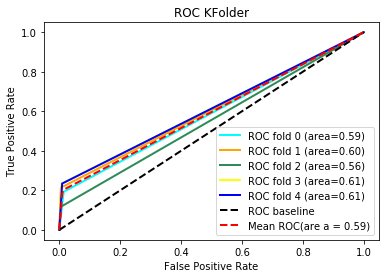

mean scores:  0.7333861640608268
mean model process time:  10.8644


In [45]:
import time
dct_scores['lgbm'], mean_score['lgbm'], mean_time['lgbm'], bst_models, y_preds = kfolder_plot(x, y, lightgbm_model)

In [46]:
train_idxs = []
test_idxs = []
kf = StratifiedKFold(n_splits=5, random_state=42,shuffle=True)
for (train_idx, test_idx) in kf.split(x, y):
    train_idxs.append(train_idx)
    test_idxs.append(test_idx)
#     print(test_idx)

In [ ]:
# for i in range(5):
# # gbm = bst_models[i]
# #     x_test = x.iloc[test_idxs[i]]
#     y_test = y.iloc[test_idxs[i]]
#     print(sum(y_test==1),sum(y_test==0))

In [ ]:
# # load model to predict
# # print('Load model to predict')
# # gbm = lgb.Booster(model_file=model_save_path)
# i = 4
# gbm = bst_models[i]
# x_test = x.iloc[test_idxs[i]]
# y_test = y.iloc[test_idxs[i]]
# print(test_idxs[i])

# # y_pred = gbm.predict(x_test)
# y_pred = y_preds[i]

# # y_pred = y_pred >= 0.5
# # print(y_pred[:10])

# from sklearn.metrics import accuracy_score, confusion_matrix
# # print(accuracy_score(y_test, y_pred))
# print("num_y_pred_1:num_y_pred_0 ={}:{} ".format(sum(y_pred>=0.5), sum(y_pred<0.5)))
# _y_pred = y_pred >= 0.5
# # print(confusion_matrix(y_true=y_test, y_pred=y_pred))
# # print(classification_report(y_true=y_test, y_pred=_y_pred))

# # AUC 
# fpr, tpr, _ = roc_curve(y_test, y_pred)
# roc_auc = auc(fpr, tpr)
# print("roc_auc: ",roc_auc)

# # plot ROC
# # plt.figure()
# # plt.rcParams['savefig.dpi'] = 50 #图片像素
# # plt.rcParams['figure.dpi'] = 100 #分辨率
# # lw = 2
# # plt.plot(fpr, tpr, color='darkorange',
# #          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
# # plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# # # plt.xlim([0.0, 1.0])
# # # plt.ylim([0.0, 1.05])
# # plt.xlim([-0.05, 1.05])
# # plt.ylim([-0.05, 1.05])
# # plt.xlabel('False Positive Rate')
# # plt.ylabel('True Positive Rate')
# # plt.title('ROC')
# # plt.legend(loc="lower right")
# # plt.show()

# feature_importance = pd.DataFrame({'name':gbm.feature_name(), 'importance':gbm.feature_importance()}).sort_values(by='importance', ascending=False)
# feature_importance.to_csv('./feat_importance.csv', index=False)
# # fig = matplotlib.pyplot.gcf()
# # fig.set_size_inches(15, 5)
# plt.rcParams['savefig.dpi'] = 50 #图片像素
# plt.rcParams['figure.dpi'] = 100 #分辨率
# feature_importance.plot(x='name', y='importance',kind='barh')
# # plt.savefig('plot123_2.png', dpi=300) 
# plt.show()

In [ ]:
# load model to predict
# print('Load model to predict')
# gbm = lgb.Booster(model_file=model_save_path)
for i in range(5):
    gbm = bst_models[i]
    x_test = x.iloc[test_idxs[i]]
    y_test = y.iloc[test_idxs[i]]
    print(test_idxs[i])

    # y_pred = gbm.predict(x_test)
    y_pred = y_preds[i]

    # y_pred = y_pred >= 0.5
    # print(y_pred[:10])

    from sklearn.metrics import accuracy_score, confusion_matrix
    # print(accuracy_score(y_test, y_pred))
    print("num_y_pred_1:num_y_pred_0 ={}:{} ".format(sum(y_pred>=0.5), sum(y_pred<0.5)))
    _y_pred = y_pred >= 0.5
    # print(confusion_matrix(y_true=y_test, y_pred=y_pred))
    print(classification_report(y_true=y_test, y_pred=_y_pred))

    # AUC 
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    print("roc_auc: ",roc_auc)

    feature_importance = pd.DataFrame({'name':gbm.feature_name(), 'importance':gbm.feature_importance()}).sort_values(by='importance', ascending=False)
    feature_importance.to_csv('./feat_importance.csv', index=False)
    # fig = matplotlib.pyplot.gcf()
    # fig.set_size_inches(15, 5)
    plt.rcParams['savefig.dpi'] = 50 #图片像素
    plt.rcParams['figure.dpi'] = 100 #分辨率
    feature_importance.plot(x='name', y='importance',kind='barh')
    # plt.savefig('plot123_2.png', dpi=300) 
    plt.show()

### SVM

In [ ]:
clf = SVC(C=0.8, kernel='rbf', class_weight='balanced')

In [ ]:
clf.fit(x_train, y_train)

In [ ]:
pred = clf.predict(x_test)

In [ ]:
print(classification_report(y_true=y_test, y_pred=pred))

### Build lightgbm model and train with above dataset

In [ ]:
# Lightgbm dataset construction

# train_data = lgb.Dataset(x_train, label=y_train)
# val_data = lgb.Dataset(x_val, label=y_val)
# test_data = lgb.Dataset(x_test, label = y_test)

feature_name = list(x.keys())
categorical_feature = [
#                        'gender',
                       'location',
#                        'level', 
#                        'properties', 
                       'car_like',
                     #'regis_year', 'regis_month', 'regis_day',
                                            ]
train_data = lgb.Dataset(x_train, 
                         label=y_train,
                         feature_name=feature_name,
                         categorical_feature=categorical_feature,
                        )
val_data = lgb.Dataset(x_val, 
                       label=y_val,
                       feature_name=feature_name,
                       categorical_feature=categorical_feature,
                      )
test_data = lgb.Dataset(x_test, 
                        label = y_test,
                        feature_name=feature_name,
                        categorical_feature=categorical_feature,
                       )
# feature_name, categorical_feature

#### Setting parameters

In [ ]:
# para searching
params = {
    'boosting_type': 'gbdt',  # np.random.choice(['dart', 'gbdt']),
    'objective': 'binary',
    'metric': ['binary_logloss', 'auc'], 
    
    'learning_rate': 0.30,
    
    'num_leaves': np.random.randint(15,20),
    'max_depth': np.random.randint(5,7),
    'min_data_in_leaf': int(2 ** (np.random.rand()*2 + 5)),
    
    'feature_fraction': np.random.rand()*0.35+0.65,
    'bagging_fraction': np.random.rand()*0.35+0.65,
    'bagging_freq': 1,
    
    'lambda_l1': 10 ** (np.random.rand() * 4),
    'lambda_l2': 10 ** (np.random.rand() * 3 + 2),
    'min_gain_to_split': 0.0,
    'min_sum_hessian_in_leaf': 0.1,
    
    'num_threads': 16,
    'verbose': 0,
    'is_training_metric': 'True'
}
print('Hyper-parameters:')
print(params)

In [ ]:
# params={'boosting_type': 'gbdt',
#         'objective': 'binary',
#         'metric': ['binary_logloss', 'auc'],
#         'learning_rate': 0.35,
#         'num_leaves': 10,
#         'max_depth': 9,
#         'min_data_in_leaf': 100,
#         'feature_fraction': 0.8815622868115178,
#         'bagging_fraction': 0.8390135637666467, 
#         'bagging_freq': 1, 
#         'lambda_l1': 31.388095945215674,
#         'lambda_l2': 9057.459915710713,
#         'min_gain_to_split': 0.0,
#         'min_sum_hessian_in_leaf': 0.1, 
#         'num_threads': 16, 'verbose': 0,
#         'is_training_metric': 'True'}

In [ ]:
# {'boosting_type': 'gbdt', 'objective': 'binary', 'metric': ['binary_logloss', 'auc'], 'learning_rate': 0.35, 'num_leaves': 16, 'max_depth': 7, 'min_data_in_leaf': 45, 'feature_fraction': 0.7185404231822985, 'bagging_fraction': 0.7205070834554599, 'bagging_freq': 1, 'lambda_l1': 2.3982232376696975, 'lambda_l2': 23817.54011963604, 'min_gain_to_split': 0.0, 'min_sum_hessian_in_leaf': 0.1, 'num_threads': 16, 'verbose': 0, 'is_training_metric': 'True'}

#### Training 

In [ ]:
evals_result = {}  # dict to store evaluation results of all the items in `valid_sets`

gbm = lgb.train(params, 
                train_data, 
                num_boost_round=10000, 
                valid_sets=[train_data, val_data], 
                valid_names = ['train', 'valid'], 
                evals_result=evals_result, 
                early_stopping_rounds=3000, 
                verbose_eval=100)

In [ ]:
train_auc_log = evals_result['train']['binary_logloss']
# type(train_auc_log)
# len(train_auc_log)
val_auc_log = evals_result['valid']['binary_logloss']

# plot training logs
plt.figure()
plt.rcParams['savefig.dpi'] = 50 #图片像素
plt.rcParams['figure.dpi'] = 100 #分辨率
lw = 2
plt.plot(range(len(train_auc_log)),train_auc_log, color='darkorange',
         lw=lw, label="train's binary_logloss")
plt.plot(range(len(val_auc_log)),val_auc_log, color='blue',
         lw=lw, label="valid's binary_logloss")
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
plt.xlabel('Boost round')
plt.ylabel("Valid's binary_logloss")
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# save best round results to csv
bst_round = np.argmax(evals_result['valid']['auc'])
trn_auc = evals_result['train']['auc'][bst_round]
trn_loss = evals_result['train']['binary_logloss'][bst_round]
val_auc = evals_result['valid']['auc'][bst_round]
val_loss = evals_result['valid']['binary_logloss'][bst_round]

In [ ]:
print('Best Round: %d'%bst_round)
print('Training loss: %.5f, Validation loss: %.5f'%(trn_loss, val_loss))
print('Training AUC : %.5f, Validation AUC : %.5f'%(trn_auc, val_auc))

# save model to file
model_save_path = './models/trn_auc' + str(trn_auc)[:5] + '_' + 'val_auc' + str(val_auc)[:5] + '.txt'
print('Save model to file: {}'.format(model_save_path))
gbm.save_model(model_save_path)

In [ ]:
feature_importance = pd.DataFrame({'name':gbm.feature_name(), 'importance':gbm.feature_importance()}).sort_values(by='importance', ascending=False)
feature_importance.to_csv('./feat_importance.csv', index=False)
# fig = matplotlib.pyplot.gcf()
# fig.set_size_inches(15, 5)
plt.rcParams['savefig.dpi'] = 50 #图片像素
plt.rcParams['figure.dpi'] = 200 #分辨率
feature_importance.plot(x='name', y='importance',kind='barh')
# plt.savefig('plot123_2.png', dpi=300) 
plt.show()

#### Using best model for Testing 

In [ ]:
# load model to predict
print('Load model to predict')
gbm = lgb.Booster(model_file=model_save_path)
                  
y_pred = gbm.predict(x_test)
# print(y_pred[:10])

y_pred = y_pred >= 0.5
# print(y_pred[:10])

from sklearn.metrics import accuracy_score, confusion_matrix
# print(accuracy_score(y_test, y_pred))
print("num_y_pred_1:num_y_pred_0 ={}:{} ".format(sum(y_pred==1), sum(y_pred==0)))
print(classification_report(y_true=y_test, y_pred=y_pred))

# AUC 
fpr, tpr,_ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print("roc_auc: ",roc_auc)

# plot ROC
plt.figure()
plt.rcParams['savefig.dpi'] = 50 #图片像素
plt.rcParams['figure.dpi'] = 100 #分辨率
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()